# 1. Giới thiệu
Trong notebook này, ta sẽ làm quen với:
- Mạng Lenet, một model dùng cho xử lý ảnh được phát triển bởi Yann Lecun
- Kiến trúc Convolution trong Deep Learning

In [38]:
# import the necessary packages
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.optimizers import SGD, RMSprop, Adam
import numpy as np
import keras
import matplotlib.pyplot as plt

1.1. Thiết lập các tham số huấn luyện

- NB_EPOCH = 10
- BATCH_SIZE = 128
- VERBOSE = 1
- OPTIMIZER = Adam()
- VALIDATION_SPLIT=0.2
- IMG_ROWS, IMG_COLS = 28
- NB_CLASSES  = 10
- INPUT SHAPE = (1, 28, 28)

In [65]:
from tensorflow.python import keras
print(keras.__version__)

2.6.0


In [39]:
seed = 1671
np.random.seed(seed)
keras.utils.set_random_seed(seed)

# YOUR CODE HERE
NB_EPOCH = 6
BATCH_SIZE = 128
VERBOSE = 1
OPTIMIZER = Adam()
VALIDATION_SPLIT=0.2

IMG_ROWS, IMG_COLS = 28, 28
NB_CLASSES = 10
input_shape = (1, IMG_ROWS, IMG_COLS)

# 2. Chuẩn bị dữ liệu

Load dataset bằng hàm mnist.load_data và đổi data_format về channels_first

In [40]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

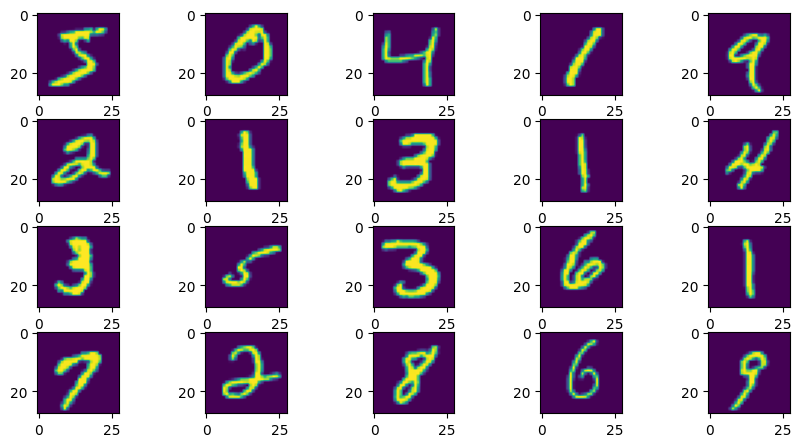

In [41]:
import matplotlib.pyplot as plt

# HIỂN THỊ DỮ LIỆU
fig = plt.figure(figsize=(10, 10))
columns = 5
rows = 4
for i in range(1, 21):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_train[i-1])
plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.3)
plt.show()

In [42]:
print(y_train[:100])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0 4 5 6 1 0 0 1 7 1 6
 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1]


In [43]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)

[0 1 2 3 4 5 6 7 8 9]
[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


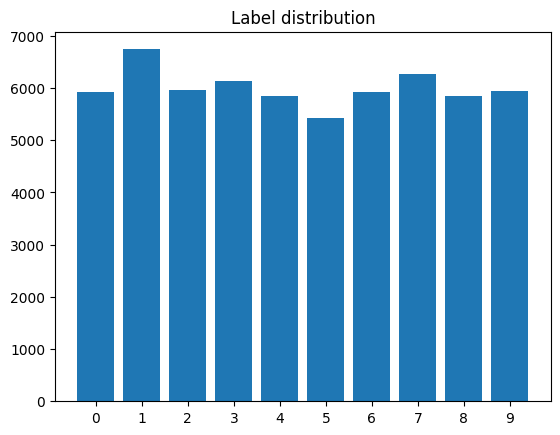

In [44]:
plt.bar(unique, counts)
plt.title("Label distribution")
plt.xticks(list(range(0, 10)))
plt.show()

In [45]:
# YOUR CODE HERE
# Dữ liệu ảnh khi đưa vào model DL sẽ có hai dạng channel last: (cao, rộng, số kênh) hoặc channel first: (số kênh, cao, rộng)
# Ở đây ta sẽ thử dùng format channels_first, ban có thể thử lập trình lại model trong ví dụ này với số kênh là channels_last để luyện thêm
K.set_image_data_format('channels_first')
# YOUR CODE HERE

1.3. Chuẩn hóa dữ liệu đầu vào, ta làm những việc sau:
- Đưa ma trận dữ liệu về kiểu float32
- Đưa giá trị pixel ảnh về miền (0,1)
- Chuyển giá trị dữ liệu về shape (:, 1, 28, 28)

In [46]:
print(x_train.dtype)

uint8


In [47]:
# YOUR CODE HERE
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# we need a 60K x [1 x 28 x 28] shape as input to the CONVNET
x_train = x_train[:, np.newaxis, :, :]
x_test = x_test[:, np.newaxis, :, :]
# YOUR CODE HERE

print(x_train.dtype)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

float32
60000 train samples
10000 test samples


Biến đổi dữ liệu đầu ra thành dạng One-hot Vector với độ dài vector = NB_CLASSES

In [48]:
# YOUR CODE HERE
y_train = to_categorical(y_train, NB_CLASSES)
y_test = to_categorical(y_test, NB_CLASSES)
# YOUR CODE HERE

print(y_train.shape)

(60000, 10)


In [49]:
y_train[:100]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 

# 4. Xây dựng mô hình


Với kiến trúc như sau:

- Conv2D(20, kernel_size=5, padding="same",input_shape=input_shape)
- Activation("relu")
- MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
- Conv2D(50, kernel_size=5, padding="same")
- Activation("relu")
- MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
- Flatten()
- Dense(500)
- Activation("relu")
- Dense(NB_CLASSES)
- Activation("softmax")

Giới thiệu về kiến trúc convolution: https://nttuan8.com/bai-6-convolutional-neural-network/

In [50]:
# YOUR CODE HERE
model = Sequential()
#CONV => RELU => POOL
model.add(Conv2D(20, kernel_size=5, padding="same",input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# CONV => RELU => POOL
model.add(Conv2D(50, kernel_size=5, padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten => RELU layers
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))

# a softmax classifier
model.add(Dense(NB_CLASSES))
model.add(Activation("softmax"))
# YOUR CODE HERE

## Compile model với các tham số sau:
- loss="categorical_crossentropy"
- optimizer=OPTIMIZER
- metrics=["accuracy"]

Đọc thêm về loss function và optimizer tại:
- https://kitchell.github.io/DeepLearningTutorial/7lossfunctionsoptimizers.html
- https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/
- https://neptune.ai/blog/performance-metrics-in-machine-learning-complete-guide#

In [51]:
print(x_train.shape)
print(y_train.shape)

# YOUR CODE HERE
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,metrics=["accuracy"])
# YOUR CODE HERE

model.summary()

(60000, 1, 28, 28)
(60000, 10)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 20, 28, 28)        520       
                                                                 
 activation_4 (Activation)   (None, 20, 28, 28)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 14, 14)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 14, 14)        25050     
                                                                 
 activation_5 (Activation)   (None, 50, 14, 14)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 7, 7)         0         
 2D)                   

# 5. Huấn luyện mô hình với các tham số sau:
- batch_size=BATCH_SIZE
- epochs=NB_EPOCH
- verbose=VERBOSE
- validation_split=VALIDATION_SPLIT

In [52]:
# YOUR CODE HERE
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
# YOUR CODE HERE

Epoch 1/6
375/375 [==============================] - 5s 13ms/step - loss: 0.1760 - accuracy: 0.9466 - val_loss: 0.0617 - val_accuracy: 0.9809
Epoch 2/6
375/375 [==============================] - 5s 12ms/step - loss: 0.0503 - accuracy: 0.9841 - val_loss: 0.0426 - val_accuracy: 0.9867
Epoch 3/6
375/375 [==============================] - 5s 12ms/step - loss: 0.0312 - accuracy: 0.9904 - val_loss: 0.0403 - val_accuracy: 0.9878
Epoch 4/6
375/375 [==============================] - 5s 12ms/step - loss: 0.0241 - accuracy: 0.9921 - val_loss: 0.0327 - val_accuracy: 0.9915
Epoch 5/6
375/375 [==============================] - 5s 12ms/step - loss: 0.0173 - accuracy: 0.9944 - val_loss: 0.0355 - val_accuracy: 0.9903
Epoch 6/6
375/375 [==============================] - 5s 12ms/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.0324 - val_accuracy: 0.9909


Đánh giá hiệu năng của mô hình với phương thức evaluate

In [53]:
# YOUR CODE HERE
score = model.evaluate(x_test, y_test, verbose=VERBOSE)
# YOUR CODE HERE
print("\nTest loss:", score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0252 - accuracy: 0.9920

Test loss: 0.02518566884100437
Test accuracy: 0.9919999837875366



Xem lại tiến trình học của mô hình theo hai tham số loss và accuracy trên training và validation data

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


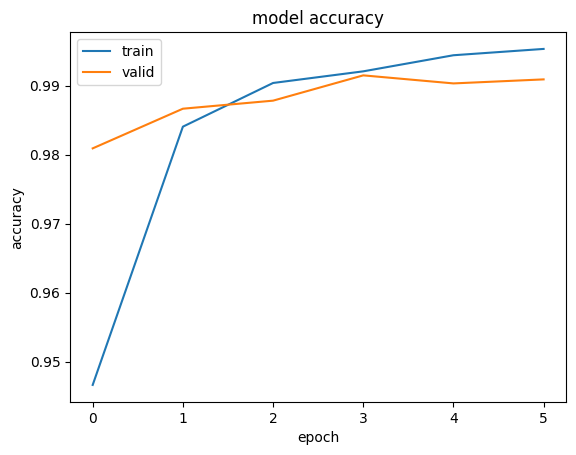

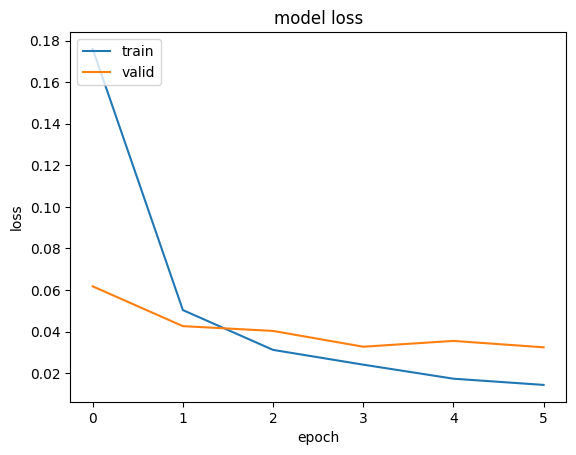

In [54]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


# 6. Save và load model

In [55]:
from keras.models import load_model
model.save('models/lenet_model.h5')  # creates a HDF5 file 'my_model.h5'
del model

In [56]:
model = load_model('models/lenet_model.h5')

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 20, 28, 28)        520       
                                                                 
 activation_4 (Activation)   (None, 20, 28, 28)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 14, 14)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 14, 14)        25050     
                                                                 
 activation_5 (Activation)   (None, 50, 14, 14)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 7, 7)         0         
 2D)                                                  

In [58]:
# YOUR CODE HERE
score = model.evaluate(x_test, y_test, verbose=VERBOSE)
# YOUR CODE HERE
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0252 - accuracy: 0.9920

Test score: 0.02518566884100437
Test accuracy: 0.9919999837875366


# Predict với model đã huấn luyện

In [59]:
# Note: Model dự đoán ra xác suất để X thuộc các nhãn từ 0 đến 9
preds = model.predict(x_test)

313/313 [==============================] - 0s 1ms/step


In [60]:
# Vector đầu ra tương ứng với một quan sát sẽ cho thấy ước lượng xác suất của các nhãn tương ứng với quan sát đó
# Bình thường trong bài toán multiclass classification, sẽ có một nhãn có xác suất cao hơn hẳn các nhãn còn lại
preds[0]

array([5.7836841e-10, 1.9741235e-09, 8.8957215e-08, 9.1269584e-07,
       1.5499623e-13, 1.6719499e-09, 2.6674247e-13, 9.9999905e-01,
       9.8564090e-10, 1.8742934e-08], dtype=float32)

In [61]:
# Chọn ra label có xác suất dự đoán lớn nhất làm dự đoán cuối cùng của mô hình
preds_final = np.argmax(preds, axis = 1)

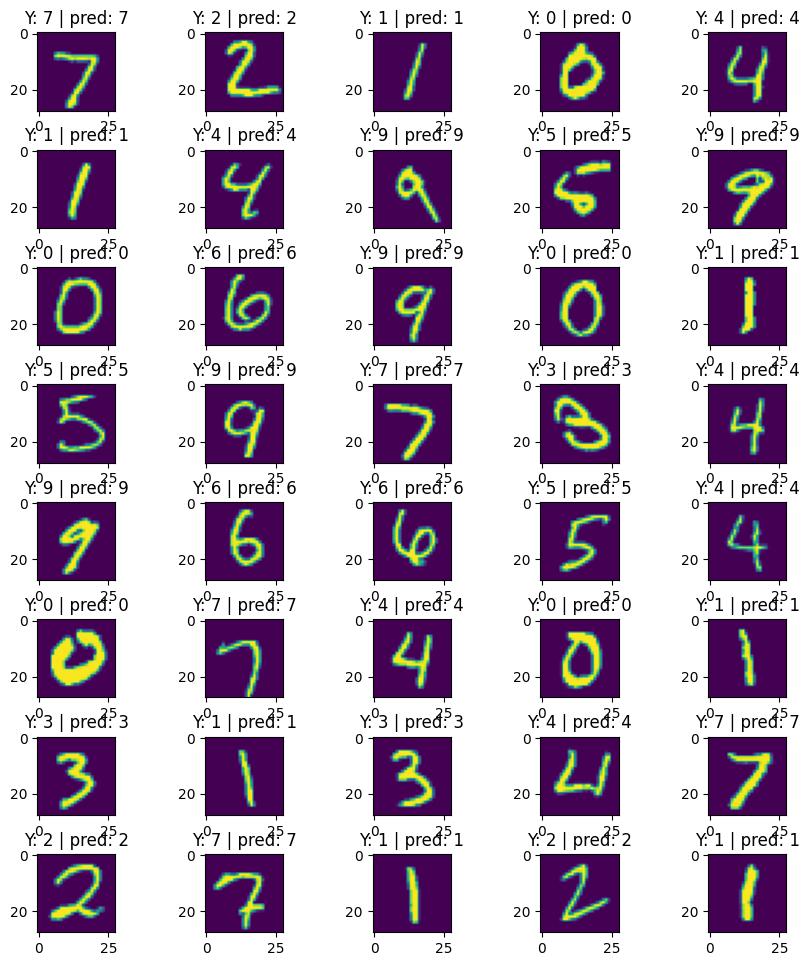

In [62]:
# Kiểm tra bằng mắt với một vài ví dụ:
fig = plt.figure(figsize=(10, 10))
columns = 5
rows = 8
for i in range(1, 41):
    idx = i-1
    y_true = np.argmax(y_test[idx])
    fig.add_subplot(rows, columns, i, title = f"Y: {y_true} | pred: {preds_final[idx]}")
    img = np.squeeze(x_test[idx])
    # ax1.title.set_text(f'{}')
    plt.imshow(img)

plt.subplots_adjust(left=0.1,
                    bottom=0.0,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.5)
plt.show()

# Hiển thị kết quả dự đoán với confusion matrix
- Confusion matrix có số hàng và cột tương ứng với số label

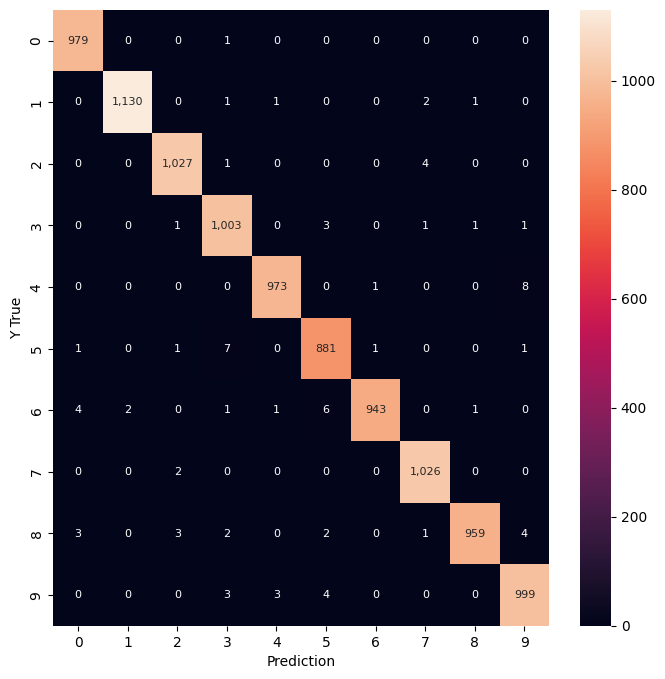

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

y_true = np.argmax(y_test, axis = 1)
confusion_mat = confusion_matrix(y_true, preds_final).astype("int")

plt.figure(figsize=(8,8))
s = sn.heatmap(confusion_mat, annot=True, fmt = ',.0f', annot_kws={"size": 8})
s.set(xlabel='Prediction', ylabel="Y True")

plt.show()

# Tính độ chính xác theo riêng từng class
Khi đánh giá mô hình, ta nên biết độ chính xác của từng class như nào để có kế hoạch thu thập dữ liệu phù hợp

In [64]:
per_class_acc = np.diag(confusion_mat)/confusion_mat.sum(axis = 1)
for i in range(0,10):
  print(f"Number {i}: accuracy {per_class_acc[i]:.4f}" )

Number 0: accuracy 0.9990
Number 1: accuracy 0.9956
Number 2: accuracy 0.9952
Number 3: accuracy 0.9931
Number 4: accuracy 0.9908
Number 5: accuracy 0.9877
Number 6: accuracy 0.9843
Number 7: accuracy 0.9981
Number 8: accuracy 0.9846
Number 9: accuracy 0.9901
